Licensed under the Apache License, Version 2.0.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import seaborn as sns
sns.reset_orig()
# matplotlib.rcParams['figure.dpi'] = 1000
# matplotlib.rcParams['lines.linewidth'] = 1.25
# Prefer whitegrid, but we use below here for consistency with other plots.
sns.set_style("whitegrid")
# sns.set()
# sns.set_palette('bright')

from google3.learning.deepmind.xmanager2.client import xmanager_api

In [ ]:
# http://go/xmanager-python-api#read-measurement-series

def get_experiment_measurements(experiment, step=-1):
  """If step is None, choose it according to argmax of val_log_likelihood."""
  data = []
  for work_unit in experiment.get_work_units():
    row = work_unit.parameters
    if step is None:
      for series in work_unit.list_measurement_series():
        if series.label == 'val_log_likelihood':
          measurements = series.measurements
          row_step = np.argmax([measurement.objective_value for measurement in measurements])
    else:
      row_step = step

    for series in work_unit.list_measurement_series():
        measurement = series.measurements[row_step]
        row[series.label] = measurement.objective_value
    row['temperature_scale'] = row_step * 0.1
    data.append(row)

  df = pd.DataFrame(data)
  return df

In [ ]:
# Vanilla CIFAR-10 results
xm_client = xmanager_api.XManagerApi(xm_deployment_env='alphabet')
xid = 17621983
experiment = xm_client.get_experiment(xid)
raw_df = get_experiment_measurements(experiment)
df = raw_df
df[['test_accuracy', 'test_ece', 'adaptive_mixup']].sort_values('test_accuracy', ascending=False)

,test_accuracy,test_ece,adaptive_mixup
12,0.972656,0.058165,False
14,0.970052,0.058919,False
0,0.969651,0.054069,False
4,0.969351,0.059183,False
6,0.969151,0.055316,False
7,0.968349,0.003997,True
16,0.967748,0.062800,False
5,0.967648,0.008559,True
2,0.967448,0.057276,False
10,0.967248,0.060533,False


In [ ]:
# Vanilla CIFAR-100 results
xm_client = xmanager_api.XManagerApi(xm_deployment_env='alphabet')
xid = 17622118
experiment = xm_client.get_experiment(xid)
raw_df = get_experiment_measurements(experiment)
df = raw_df
df[['test_accuracy', 'test_ece', 'adaptive_mixup']].sort_values('test_accuracy', ascending=False)

,test_accuracy,test_ece,adaptive_mixup
14,0.823618,0.059302,False
16,0.822115,0.063790,False
4,0.821715,0.061333,False
2,0.820312,0.054766,False
0,0.820012,0.058136,False
8,0.819010,0.054863,False
12,0.818810,0.059517,False
15,0.818810,0.032775,True
10,0.818710,0.056391,False
6,0.818009,0.061363,False


In [ ]:
xm_client = xmanager_api.XManagerApi(xm_deployment_env='alphabet')
xid = 17634418
experiment = xm_client.get_experiment(xid)
# Select optimal temperature for BE+Mixup: 0.5.
raw_df = get_experiment_measurements(experiment, step=5)
# Select optimal temperature for BE+CAMixup. It changes quite a bit for
# each hyperparameter setting. So we just get optimal temperature dynamically.
raw_df2 = get_experiment_measurements(experiment, step=None)
# Select vanilla results via temperature=1.0. Could get from
# original experiment but it doesn't include corrupted
# results.
raw_df3 = get_experiment_measurements(experiment, step=10)

In [ ]:
xm_client = xmanager_api.XManagerApi(xm_deployment_env='alphabet')
xid = 17634449  # CIFAR-100
experiment = xm_client.get_experiment(xid)
# Select optimal temperature for BE+Mixup: 0.7.
raw_df = get_experiment_measurements(experiment, step=7)
# Select optimal temperature for BE+CAMixup. It changes quite a bit for
# each hyperparameter setting. So we just get optimal temperature dynamically.
raw_df2 = get_experiment_measurements(experiment, step=None)
# Select vanilla results via temperature=1.0. Could get from
# original experiment but it doesn't include corrupted
# results.
raw_df3 = get_experiment_measurements(experiment, step=10)

In [ ]:
def build_dataframe(raw_df, raw_df2, raw_df3):
  # Build data frame with three sets of experiments:
  # 1. BE+Mixup (raw_df3)
  # 2. TS+BE+Mixup (raw_df)
  # 3. BE+CAMixup (raw_df3)
  # 4. TS+BE+CAMixup (raw_df2)
  df = raw_df
  df['adaptive_mixup'] = df['model_dir'].str.contains('adaptive_mixup=True')
  df = df[df['adaptive_mixup'] == False]

  df2 = raw_df2
  df2['adaptive_mixup'] = df2['model_dir'].str.contains('adaptive_mixup=True')
  df2 = df2[df2['adaptive_mixup'] == True]

  df3 = raw_df3
  df3['adaptive_mixup'] = df3['model_dir'].str.contains('adaptive_mixup=True')

  df = pd.concat([df, df2, df3])
  return df

def plot(df, label):
  xs = [
      # df[(df['temperature_scale'] == 1.0) & (df['adaptive_mixup'] == False)][label],
      # df[(df['temperature_scale'] != 1.0) & (df['adaptive_mixup'] == False)][label],
      df[(df['temperature_scale'] == 1.0) & (df['adaptive_mixup'] == True)][label],
      df[(df['temperature_scale'] != 1.0) & (df['adaptive_mixup'] == True)][label],
  ]
  if 'accuracy' in label:
    xs = [[1. - entry for entry in row] for row in xs]
  if 'accuracy' in label or 'ece' in label:
    xs = [[entry * 100. for entry in row] for row in xs]
  if 'log_likelihood' in label:
    xs = [[-entry for entry in row] for row in xs]
  fig = sns.boxplot(data=xs)
  # plt.xticks(range(4), ['Mixup', 'TS+Mixup', 'CAMixup', 'TS+CAMixup'])
  plt.xticks(range(2), ['CAMixup', 'TS+CAMixup'])
  plt.tight_layout()
  return fig

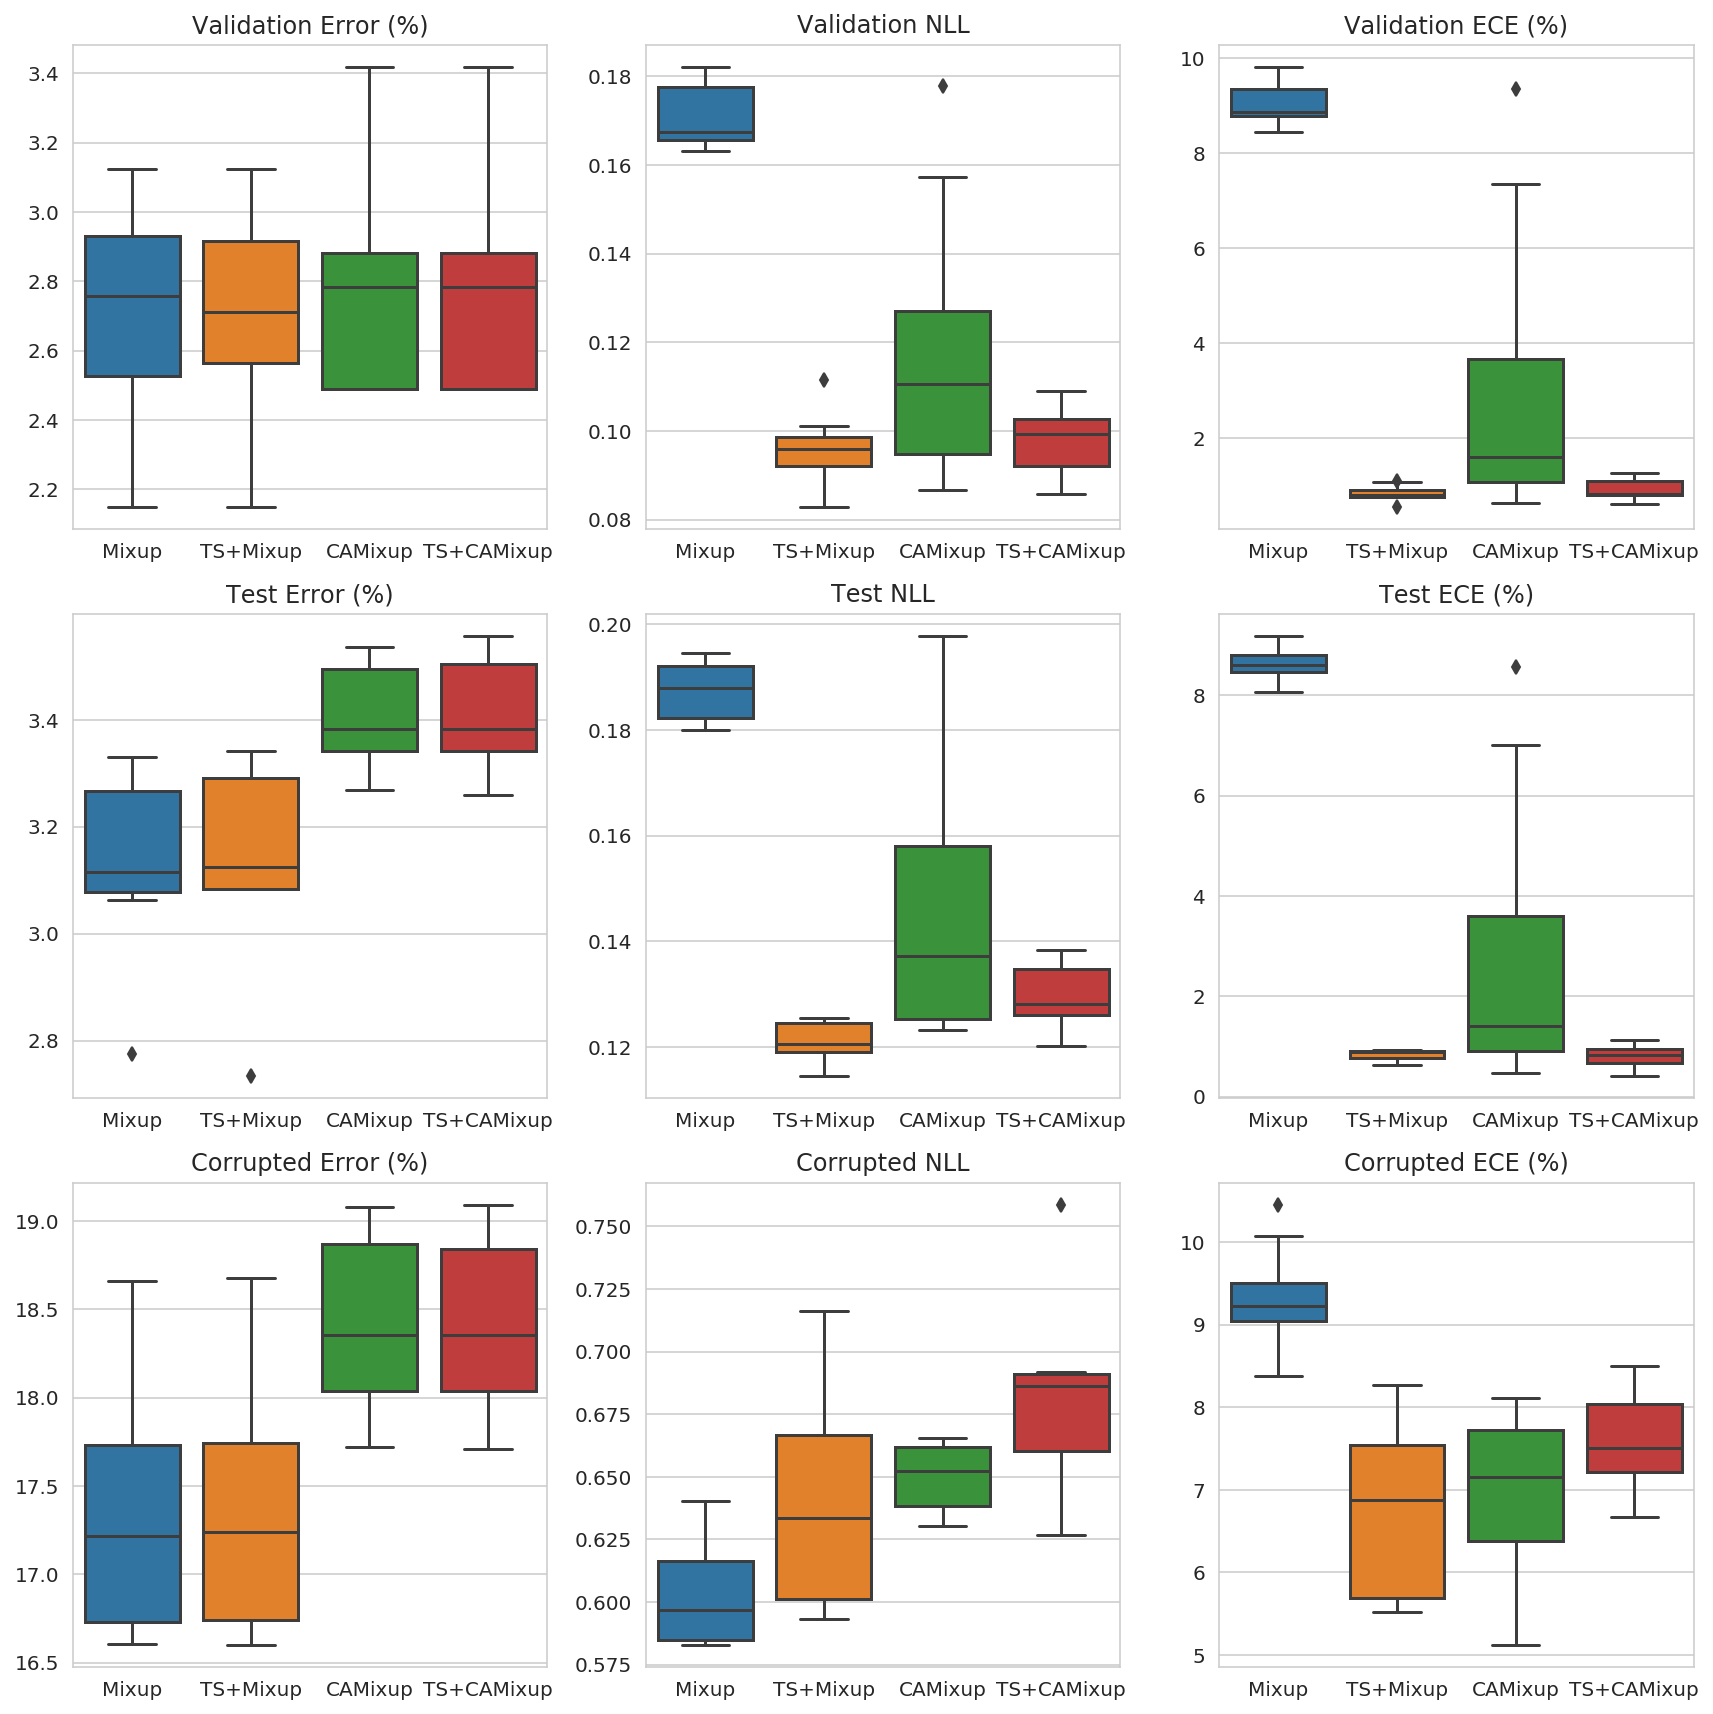

In [ ]:
df = build_dataframe(raw_df, raw_df2, raw_df3)
labels = [
    'val_accuracy',
    'val_log_likelihood',
    'val_ece',
    'test_accuracy',
    'test_log_likelihood',
    'test_ece',
    'test_accuracy_mean_corrupted',
    'test_nll_mean_corrupted',
    'test_ece_mean_corrupted',
]
titles = [
    'Validation Error (%)',
    'Validation NLL',
    'Validation ECE (%)',
    'Test Error (%)',
    'Test NLL',
    'Test ECE (%)',
    'Corrupted Error (%)',
    'Corrupted NLL',
    'Corrupted ECE (%)',
]
plt.figure(figsize=(12., 12.))
for i, (label, title) in enumerate(zip(labels, titles)):
  # plt.figure(figsize=(5.0, 5.0))
  plt.subplot(3, 3, i + 1)
  plot(df, label)
  plt.title(title)
  # plt.savefig('ts-accuracy-val.pdf')
  # %download_file ts-accuracy-val.pdf

plt.savefig('temperature-scaling.pdf')
%download_file temperature-scaling.pdf

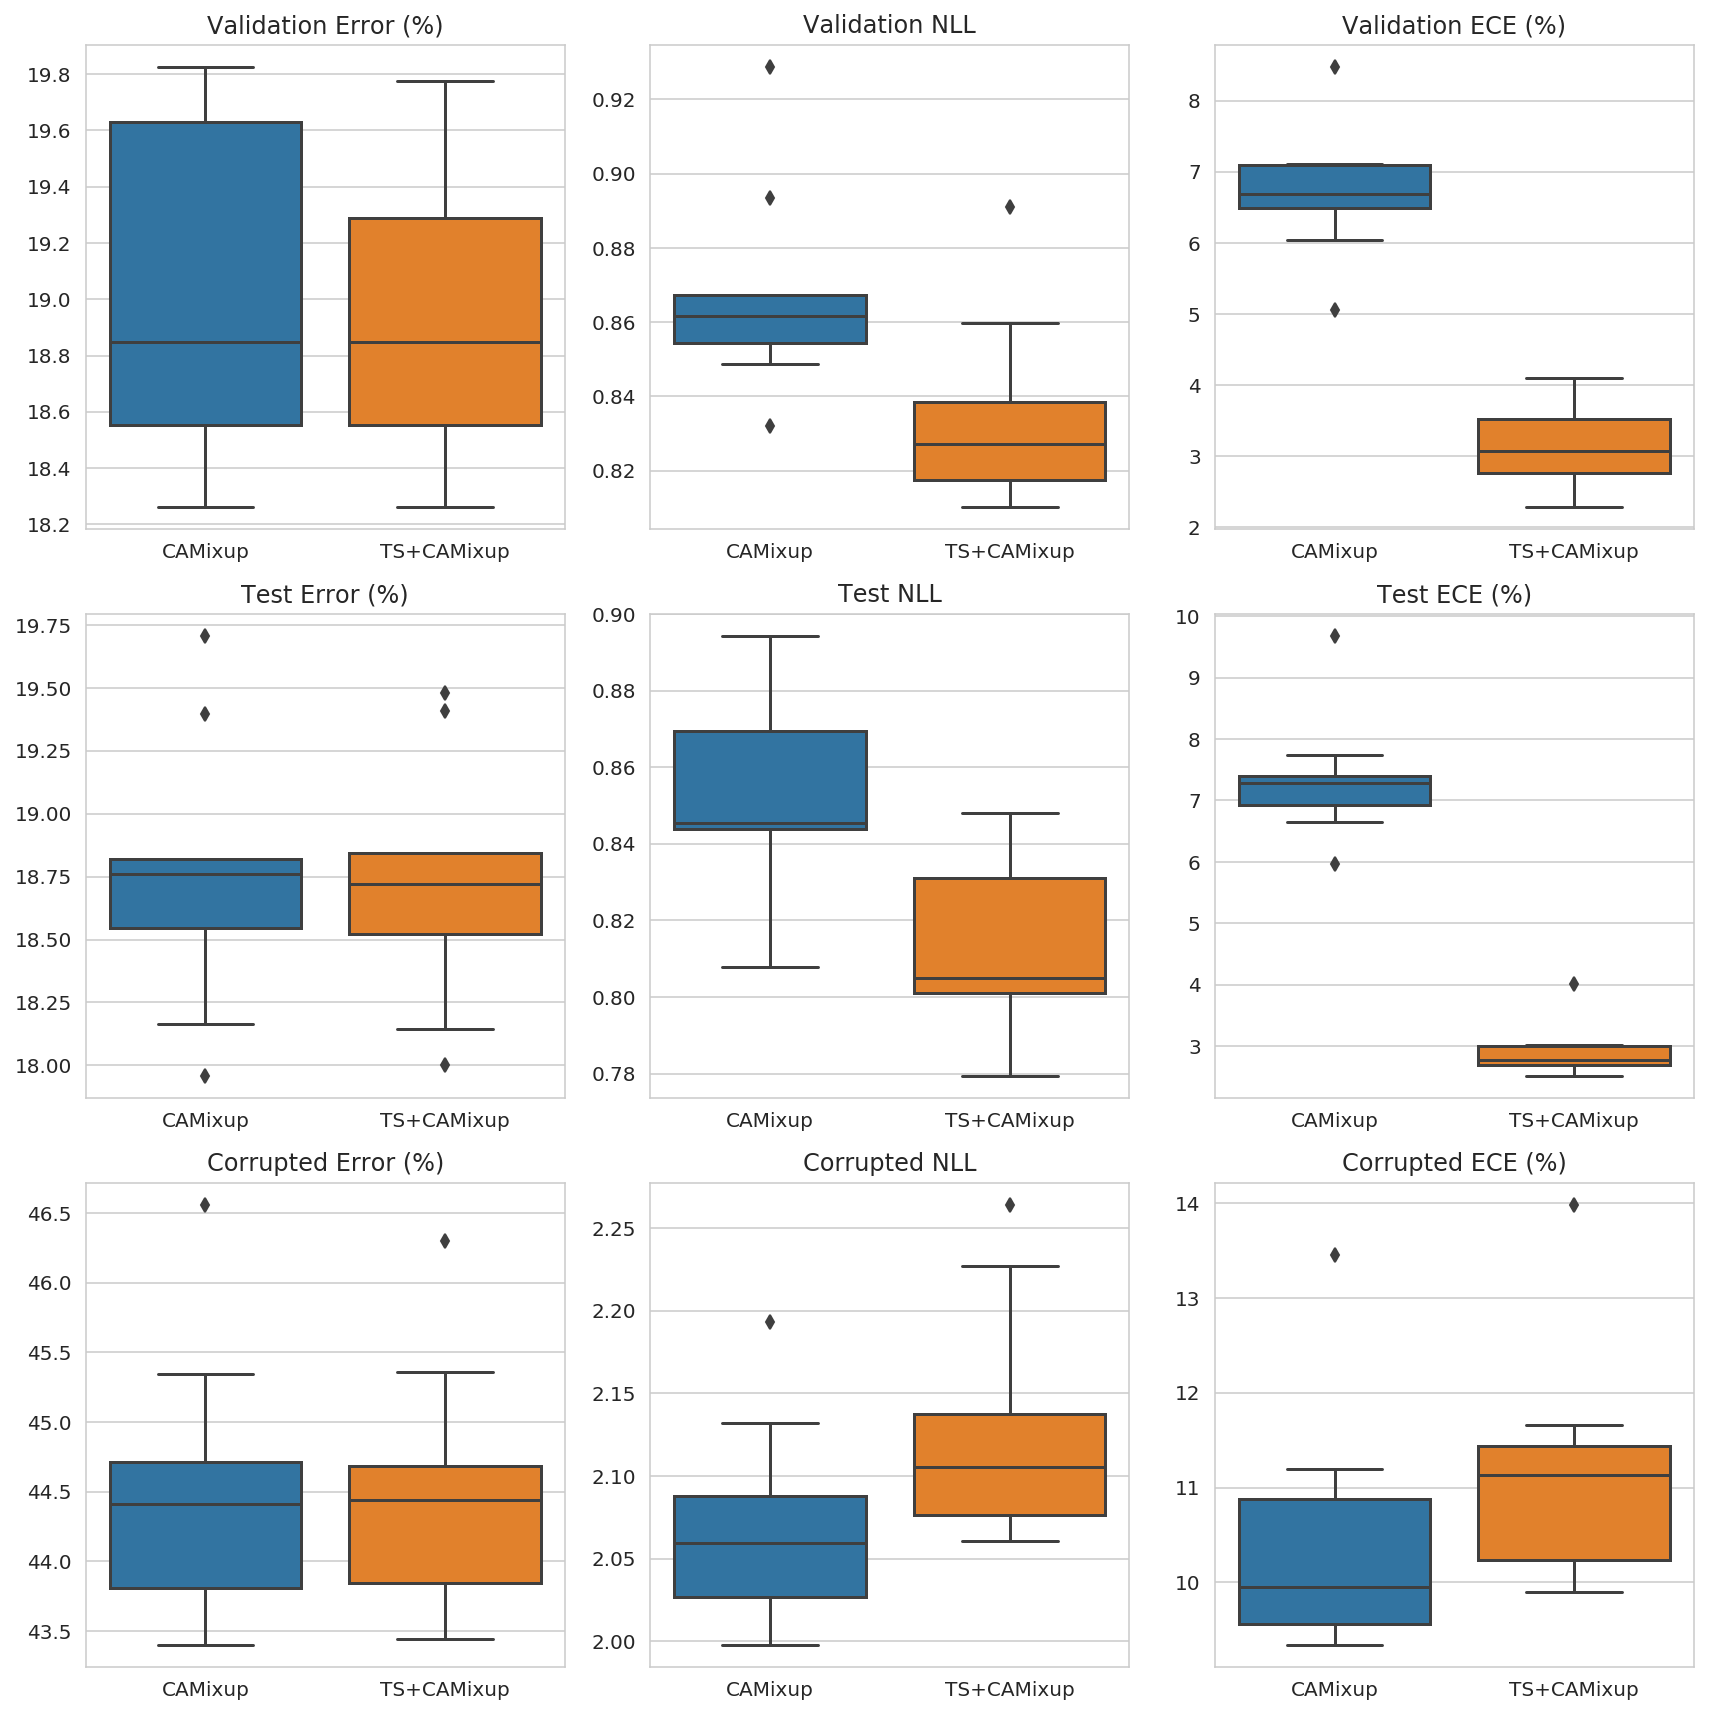

In [ ]:
df = build_dataframe(raw_df, raw_df2, raw_df3)
labels = [
    'val_accuracy',
    'val_log_likelihood',
    'val_ece',
    'test_accuracy',
    'test_log_likelihood',
    'test_ece',
    'test_accuracy_mean_corrupted',
    'test_nll_mean_corrupted',
    'test_ece_mean_corrupted',
]
titles = [
    'Validation Error (%)',
    'Validation NLL',
    'Validation ECE (%)',
    'Test Error (%)',
    'Test NLL',
    'Test ECE (%)',
    'Corrupted Error (%)',
    'Corrupted NLL',
    'Corrupted ECE (%)',
]
plt.figure(figsize=(12., 12.))
for i, (label, title) in enumerate(zip(labels, titles)):
  # plt.figure(figsize=(5.0, 5.0))
  plt.subplot(3, 3, i + 1)
  plot(df, label)
  plt.title(title)
  # plt.savefig('ts-accuracy-val.pdf')
  # %download_file ts-accuracy-val.pdf

plt.savefig('temperature-scaling.pdf')
%download_file temperature-scaling.pdf